## Plot posteriors for a single star

In [1]:
import os
default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import lsdb
import matplotlib.pyplot as plt
import nested_pandas as npd
import numpy as np
import pandas as pd

from scipy.interpolate import griddata
from photod.bayes import makeBayesEstimates3d
from photod.locus import LSSTsimsLocus, subsampleLocusData, get3DmodelList
from photod.parameters import GlobalParams
from photod.bayes import plotStars

from astropy import units as u
from astropy.coordinates import SkyCoord

pd.set_option('display.max_columns', None)

In [2]:
prior_map_url = "/mnt/beegfs/scratch/data/priors/hats/s82_priors"
prior_map_catalog = lsdb.read_hats(prior_map_url)
prior_map_catalog

,rmag,kde,xGrid,yGrid,Norder,Dir,Npix
npartitions=207,,,,,,,
"Order: 5, Pixel: 0",double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
"Order: 5, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...,...,...


In [3]:
locus_path = "../../data/MSandRGBcolors_v1.3.txt"
fitColors = ("ug", "gr", "ri", "iz")
LSSTlocus = LSSTsimsLocus(fixForStripe82=False, datafile=locus_path)
OKlocus = LSSTlocus[(LSSTlocus["gi"] > 0.2) & (LSSTlocus["gi"] < 3.55)]
locusData = subsampleLocusData(OKlocus, kMr=10, kFeH=2)
# locusData = subsampleLocusData(OKlocus, kMr=1, kFeH=1)
ArGridList, locus3DList = get3DmodelList(locusData, fitColors)
globalParams = GlobalParams(fitColors, locusData, ArGridList, locus3DList)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


In [4]:
def makeBayesEstimatesSingleStar(partition, map_partition, globalParams):
    priorGrid = {}
    for rind, r in enumerate(np.sort(map_partition["rmag"].to_numpy())):
        # interpolate prior map onto locus Mr-FeH grid
        Z = map_partition[map_partition["rmag"] == r]
        Zval = np.frombuffer(Z.iloc[0]["kde"], dtype=np.float64).reshape((96, 36))
        X = np.frombuffer(Z.iloc[0]["xGrid"], dtype=np.float64).reshape((96, 36))
        Y = np.frombuffer(Z.iloc[0]["yGrid"], dtype=np.float64).reshape((96, 36))
        points = np.array((X.flatten(), Y.flatten())).T
        values = Zval.flatten()
        # actual (linear) interpolation
        priorGrid[rind] = griddata(
            points, values, (globalParams.locusData["FeH"], globalParams.locusData[globalParams.MrColumn]), method="linear", fill_value=0
        )
    priorGrid = jax.numpy.array(list(priorGrid.values()))
    _, results = makeBayesEstimates3d(partition, priorGrid, globalParams, returnAllInfo=True)
    return results


In [5]:
from mocpy import MOC
import astropy.units as u
from lsdb.core.search.moc_search import MOCSearch

def computeBayesEstimates(stars, map_catalog, globalParams):
    max_order = map_catalog.hc_structure.pixel_tree.get_max_depth()
    results = []
    for index in range(len(stars)):
        star = stars.iloc[[index]]
        lon = star["ra"].to_numpy()*u.deg
        lat = star["dec"].to_numpy()*u.deg
        map_moc = MOC.from_lonlat(lon,lat,max_norder=max_order)
        map_partition_df = map_catalog.search(MOCSearch(map_moc, fine=False)).compute()
        results.append(makeBayesEstimatesSingleStar(star, map_partition_df, globalParams))
    return results

In [6]:
cols = "glon       glat      comp   logg    FeH      Mr      DM      Ar  rmagObs0   ug0     gr0     ri0     iz0    rmag   ugObs   grObs   riObs   izObs   uErr   gErr   rErr   iErr   zErr    ugSL    grSL    riSL    izSL ugErrSL grErrSL riErrSL izErrSL".split()
vals = "66.88731266 -49.16282181    3    4.50  -2.00    5.12   17.85   0.150   23.12   0.777   0.309   0.100   0.046   23.13   0.838   0.369   0.136   0.075  0.059  0.012  0.010  0.012  0.019   0.860   0.380   0.142   0.050   0.061   0.016   0.016   0.023".split()

_ = pd.DataFrame.from_dict({c: [float(v)] for c, v in zip(cols, vals)})

# rmag, ugObs... = generirane iz modela, sa šumom i ekstinkcijom
# greške za boje *Obs treba odrediti iz magnituda

c = SkyCoord(l=_['glon'].to_numpy()*u.degree, b=_['glat'].to_numpy()*u.degree, frame='galactic').transform_to('icrs')
_['ra'] = c.ra
_['dec'] = c.dec

_['ugErr'] = np.sqrt(_['uErr']**2+_['gErr']**2)
_['grErr'] = np.sqrt(_['gErr']**2+_['rErr']**2)
_['riErr'] = np.sqrt(_['rErr']**2+_['iErr']**2)
_['izErr'] = np.sqrt(_['iErr']**2+_['zErr']**2)

_.rename(columns={"ugObs":"ug", "grObs":"gr", "riObs":"ri", "izObs":"iz"}, inplace=True)

star = _["glon glat ra dec FeH Mr DM Ar rmag ug gr ri iz ugErr grErr riErr izErr".split()]
star

,glon,glat,ra,dec,FeH,Mr,DM,Ar,rmag,ug,gr,ri,iz,ugErr,grErr,riErr,izErr
0,66.887313,-49.162822,340.004837,-1.141657,-2.0,5.12,17.85,0.15,23.13,0.838,0.369,0.136,0.075,0.060208,0.01562,0.01562,0.022472


Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0...
pts: 25 155


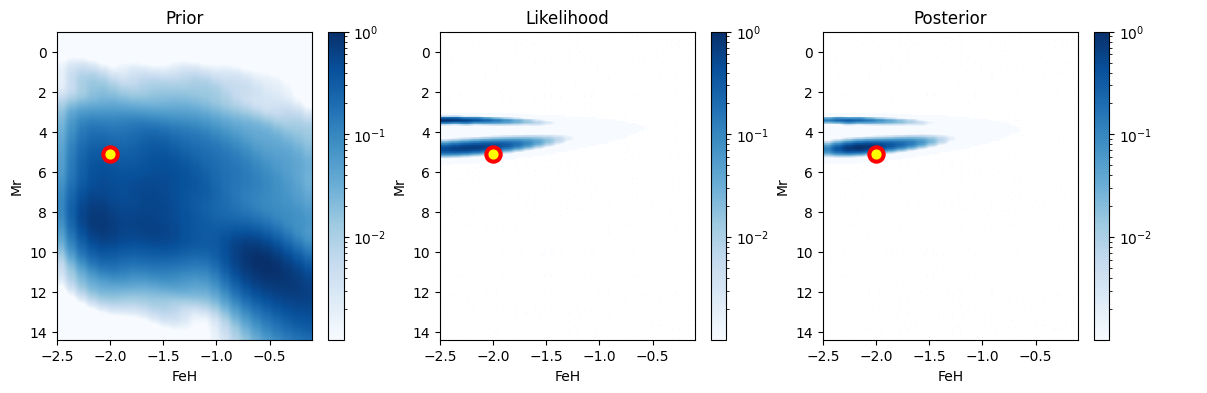

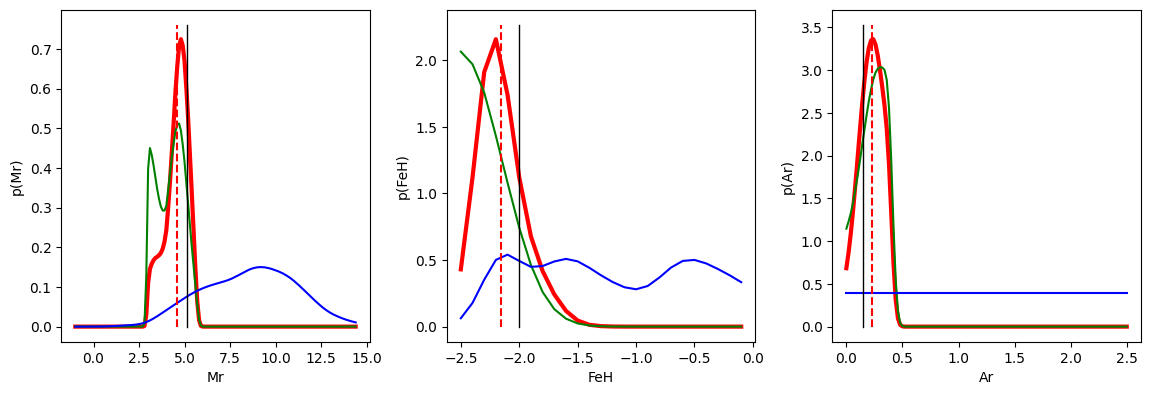

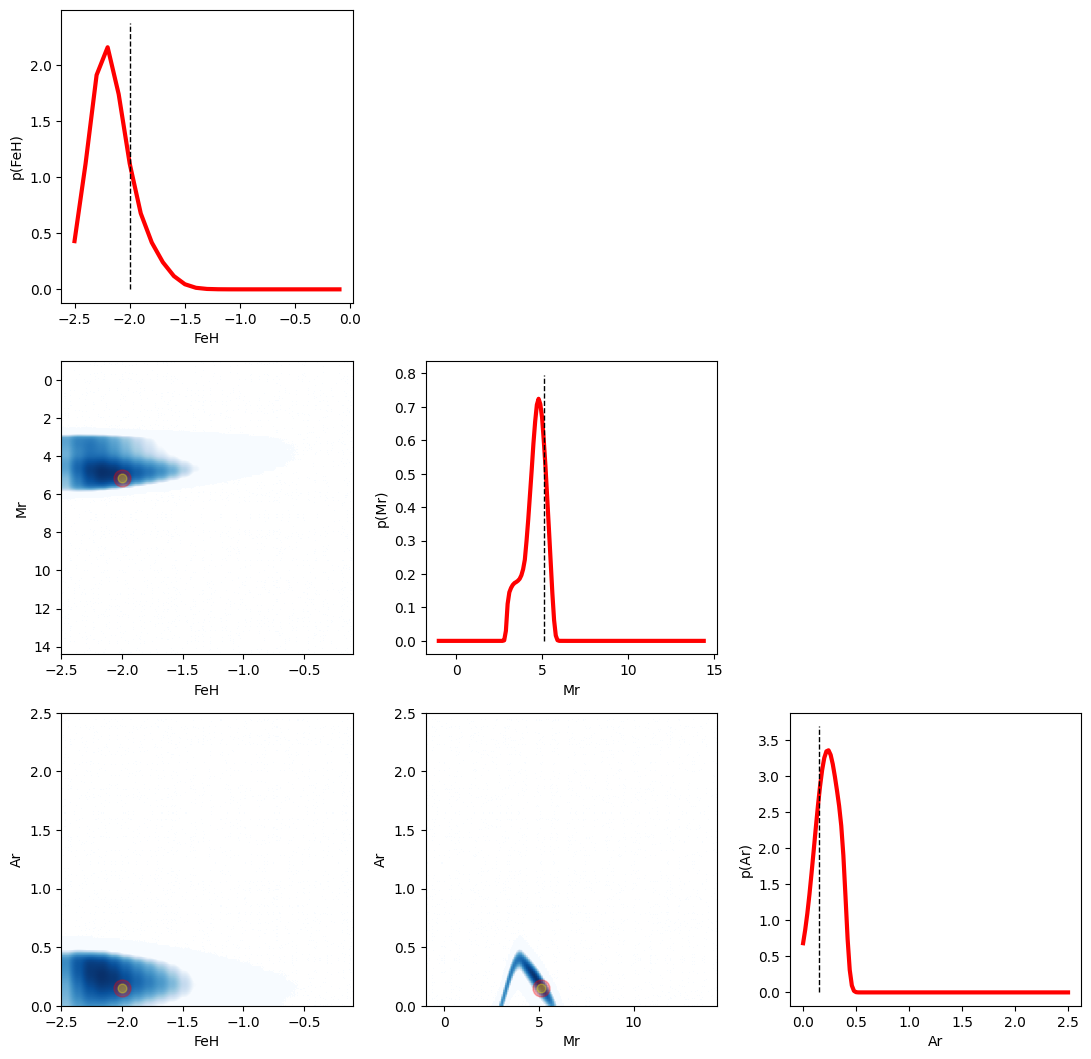

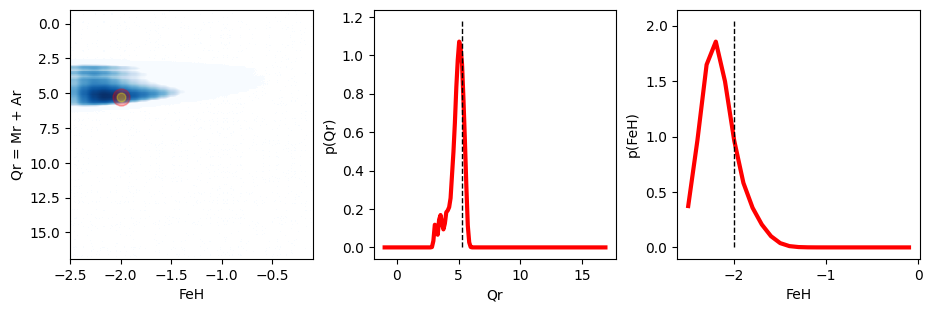

4.8340087 0.59558743


In [7]:
from photod.bayes import plotStars

results = computeBayesEstimates(star, prior_map_catalog, globalParams)

plotStars(
    star.iloc[[0]].reset_index(drop=True),
    *results[0].getPlottingArgs(),
    *globalParams.getPlottingArgs(),
    starIndices=[0]
)